In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from gym import spaces
from gym.envs.toy_text import BlackjackEnv
from tqdm.auto import tqdm, trange

from collections import defaultdict

# Часть первая.

Почему-то при создании env через gym.make("BlackJack-v1", natural=True) параметр natural игнорируется. Эту ошибку еле отловил.

In [2]:
env = BlackjackEnv(natural=True)

In [3]:
def run_episode(env, policy):
    state, info = env.reset()
    is_done = False
    rewards = []
    actions = []
    states = []
    while not is_done:
        action = policy(state)
        actions.append(action)
        states.append(state)
        state, reward, is_done, truncated, info = env.step(action)
        rewards.append(reward)
    return states, actions, rewards

## 1. Простейшая стратегия

In [4]:
def naive_policy(observation):
    if observation[0] < 19:
        return 1
    else:
        return 0

In [5]:
def mc_prediction_first_visit(env, policy, gamma, n_episode):
    V = defaultdict(int)
    N = defaultdict(int)
    mean_reward = 0
    mean_sqr_reward = 0
    for episode in trange(n_episode):
        states_t, _, rewards_t = run_episode(env, policy)
        total_reward = np.sum(rewards_t)
        mean_reward += total_reward / n_episode
        mean_sqr_reward += total_reward ** 2 / n_episode
        return_t = 0
        G = {}
        for state_t, reward_t in zip(states_t[1::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[state_t] = return_t
        for state, return_t in G.items():
            if state[0] <= 21:
                V[state] += return_t
                N[state] += 1
    for state in V:
        V[state] = V[state] / N[state]
    return V, mean_reward, np.sqrt((mean_sqr_reward - mean_reward ** 2) / n_episode)

  0%|          | 0/500000 [00:00<?, ?it/s]

Средняя награда простой стратегии: -0.18±0.00


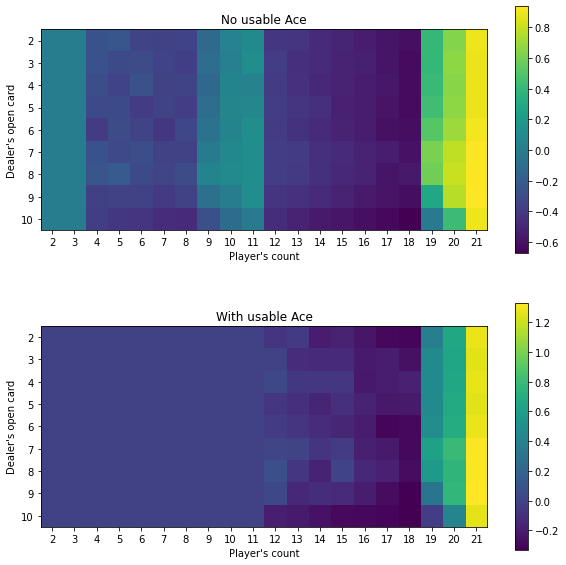

In [6]:
V, mean_reward, mean_reward_err = mc_prediction_first_visit(env, naive_policy, 1, 500_000)

print(f"Средняя награда простой стратегии: {mean_reward:.2f}±{mean_reward_err:.2f}")

plt.figure(figsize=(10, 10))

plt.subplot(211)

data = [[V[(i, j, False)] for i in range(2, 21+1)] for j in range(2, 10+1)]
plt.imshow(data)
plt.colorbar()
plt.xticks(np.arange(20), np.arange(2, 21+1))
plt.yticks(np.arange(9), np.arange(2, 10+1))
plt.xlabel("Player's count")
plt.ylabel("Dealer's open card")
plt.gca().set_title("No usable Ace")

plt.subplot(212)

data = [[V[(i, j, True)] for i in range(2, 21+1)] for j in range(2, 10+1)]
plt.imshow(data)
plt.colorbar()
plt.xticks(np.arange(20), np.arange(2, 21+1))
plt.yticks(np.arange(9), np.arange(2, 10+1))
plt.xlabel("Player's count")
plt.ylabel("Dealer's open card")
plt.gca().set_title("With usable Ace");

## 2-3. Off-policy MC-control

Здесь и далее будут исследоваться два варианта Off-policy Monte-Carlo control: с использованием равномерно-случайной стратегии для оценки Q, и с эпсилон-жадной.

In [7]:
def make_policy_from_dict(policy_dict):
    def policy(observation):
        return policy_dict.get(observation, 0)
    return policy

In [8]:
def test_policy(env, policy, test_size):
    mean_reward = 0
    for _ in trange(test_size, leave=False):
        _, _, rewards = run_episode(env, policy)
        episode_reward = np.sum(rewards)
        mean_reward += episode_reward / test_size
    return mean_reward

In [9]:
def mc_control_off_policy(env, gamma, n_episode, exploration_policy="random", eps=0.05, eval_every=10_000, eval_size=100_000):
    n_action = env.action_space.n
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.zeros(n_action))

    def random_policy(state):
        return np.random.randint(n_action)

    def eps_greedy_policy(state):
        if np.random.rand() < eps:
            return np.random.randint(n_action)
        else:
            return torch.argmax(Q[state]).item()

    eval_mean = []

    if exploration_policy == "random":
        policy = random_policy
    elif exploration_policy == "eps_greedy":
        policy = eps_greedy_policy
    else:
        raise ValueError(f"Unknown policy {exploration_policy}")

    for episode in trange(n_episode):
        W = 1
        states_t, actions_t, rewards_t = run_episode(env, policy)
        return_t = 0
        for state_t, action_t, reward_t in zip(
            states_t[::-1],
            actions_t[::-1],
            rewards_t[::-1]
        ):
            return_t = gamma * return_t + reward_t
            N[(state_t, action_t)] += W
            Q[state_t][action_t] += (W / N[(state_t, action_t)]) * (return_t - Q[state_t][action_t])
            if action_t != torch.argmax(Q[state_t]).item():
                break   #  формально умножаем W на 0, т.к. p(A_t | S_t, true_policy) = 0 (числитель)
            if exploration_policy == "random":
                W *= n_action  #  1 / p(A_t | S_t, random_policy) = 1 / (1/n_action) = n_action
            elif exploration_policy == "eps_greedy":
                W *= 1 / (1 - eps + eps/n_action)

        if (episode + 1) % eval_every == 0:
            optimal_policy_dict = {}
            for state, actions in Q.items():
                optimal_policy_dict[state] = torch.argmax(actions).item()
            optimal_policy = make_policy_from_dict(optimal_policy_dict)
            mean_reward = test_policy(env, optimal_policy, test_size=eval_size)
            eval_mean.append(mean_reward)

    optimal_policy_dict = {}
    for state, actions in Q.items():
        optimal_policy_dict[state] = torch.argmax(actions).item()
    optimal_policy = make_policy_from_dict(optimal_policy_dict)

    return Q, optimal_policy, np.array(eval_mean)

In [10]:
_, optimal_policy_default_rand, eval_rand = mc_control_off_policy(env, 1, 500_000, eval_every=25_000, exploration_policy="random")

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [11]:
_, optimal_policy_default_eps, eval_eps = mc_control_off_policy(env, 1, 500_000, eval_every=25_000, exploration_policy="eps_greedy")

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

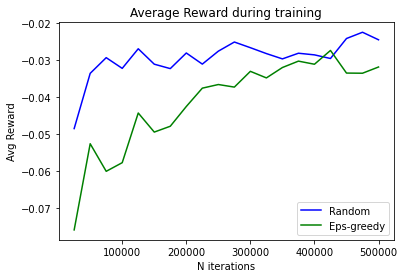

In [12]:
plt.plot(np.arange(25_000, 500_000 + 1, 25_000), eval_rand, color='b', label="Random")
plt.plot(np.arange(25_000, 500_000 + 1, 25_000), eval_eps, color='g', label="Eps-greedy")
plt.title("Average Reward during training")
plt.xlabel("N iterations")
plt.ylabel("Avg Reward")
plt.legend();

Количество возможных состояний не очень большое, а длина эпизодов маленькая (1-3 шага в основном). Поэтому случайная стратегия быстрее выходит на оптимум.

# Часть вторая.

## 4. Блэкджек с удвоением

In [13]:
class BlackJackDoubleEnv(BlackjackEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.action_space = spaces.Discrete(3)

    def step(self, action):
        if action < 2:
            return super().step(action)
        else:
            obs, reward, _, _, _ = super().step(1)
            if reward > -1.0:
                obs, reward, _, _, _ = super().step(0)
            reward *= 2
            terminated = True
            return obs, reward, terminated, False, {}

In [14]:
env_double = BlackJackDoubleEnv(natural=True)

In [15]:
mean_reward = test_policy(env_double, optimal_policy_default_rand, test_size=500_000)
print(f"Средний выигрыш стратегии без удвоения: {mean_reward:.2f}")

  0%|          | 0/500000 [00:00<?, ?it/s]

Средний выигрыш стратегии без удвоения: -0.03


Проверяем, что результаты стратегии, неумеющей в удвоение, не отличаются на новом энве. Как раз так я и смог обнаружить проблему с gym.make. К тому же будет с чем сравнивать, чтобы понять есть ли толк от удвоения.

## 5. Off-policy MC-control

In [16]:
_, optimal_policy_double_rand, eval_double_rand = mc_control_off_policy(env_double, 1, 500_000,
                                                                        eval_every=25_000,
                                                                        exploration_policy="random")

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [17]:
_, optimal_policy_double_eps, eval_double_eps = mc_control_off_policy(env_double, 1, 500_000,
                                                                      eval_every=25_000,
                                                                      exploration_policy="eps_greedy")

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

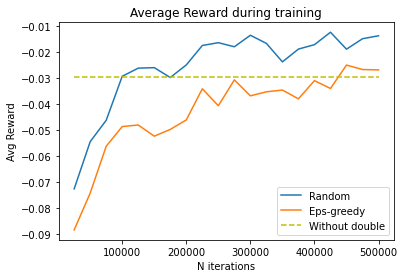

In [18]:
plt.plot(np.arange(25_000, 500_000 + 1, 25_000), eval_double_rand, label="Random")
plt.plot(np.arange(25_000, 500_000 + 1, 25_000), eval_double_eps, label="Eps-greedy")
plt.hlines(mean_reward, 25_000, 500_000, label="Without double", color="y", linestyles="--")
plt.title("Average Reward during training")
plt.xlabel("N iterations")
plt.ylabel("Avg Reward")
plt.legend(loc="lower right");

Видно, что добавление удвоения действительно позволяет увеличить среднюю награду. Количество состоянии и длительности эпизодов всё еще небольшие, поэтому случайная стратегия так же обеспечивает более быстрое схождение к оптимуму.

# Часть третья.

## 6. Блэкджек с подсчетом

In [19]:
import random


def cmp(a, b):
    return float(a > b) - float(a < b)


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):
    return sum_hand(hand) > 21


def score_hand(hand):
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackJackCountingEnv(gym.Env):
    price_dict = {
        1: -1,
        2: 0.5,
        3: 1,
        4: 1,
        5: 1.5,
        6: 1,
        7: 0.5,
        8: 0,
        9: -0.5,
        10: -1
    }

    def __init__(self):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(21),  # Округленный HiLo счет от -10 до +10
        ))
        self.score = 0
        self.deck = []
        self.dealer = []
        self.player = []

    def _reset_deck(self):
        self.deck = [1] * 4 + [2] * 4 + [3] * 4 + [4] * 4 + [5] * 4 + [6] * 4 + [7] * 4 + [8] * 4 + [9] * 4 + [10] * 4 * 4
        random.shuffle(self.deck)

    def _draw_card(self):
        card = self.deck.pop()
        self.score += self.price_dict[card]
        return card

    def _get_obs(self):
        return sum_hand(self.player), self.player[0], usable_ace(self.player), int(np.clip(np.round(self.score), -10, 10)) + 10

    def reset(self, *args, **kwargs):
        super().reset(*args, **kwargs)
        self._reset_deck()
        self.score = 0.
        self.dealer = [self._draw_card(), self.deck.pop()]  # one card is face-down, so we don't count it in score until the round is over
        self.player = [self._draw_card(), self._draw_card()]
        return self._get_obs(), {}

    def render(self):
        BlackjackEnv.render(self)

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:
            self.player.append(self._draw_card())
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        if action == 0:
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self._draw_card())
            reward = cmp(score_hand(self.player), score_hand(self.dealer))
            if is_natural(self.player) and reward == 1.0:
                reward = 1.5
        if action == 2:
            terminated = True
            self.player.append(self._draw_card())
            if is_bust(self.player):
                reward = -2.0
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self._draw_card())
                reward = 2 * cmp(score_hand(self.player), score_hand(self.dealer))
        if terminated:
            self.score += self.price_dict[self.dealer[1]]
            if len(self.deck) < 15:
                terminated = True
            else:
                terminated = False
                self.dealer = [self._draw_card(), self.deck.pop()]  # one card is face-down, so we don't count it in score until the round is over
                self.player = [self._draw_card(), self._draw_card()]
        return self._get_obs(), reward, terminated, False, {}

In [20]:
env_count = BlackJackCountingEnv()

In [21]:
def adopt_policy(policy_double):
    def adopted_policy(state):
        return policy_double(state[:3])
    return adopted_policy

В этой версии окружения меняется определение эпизода - если в предыдущих частях один эпизод = одна раздача, то теперь эпизодом считается проход одной колоды до её перемешивания.
Поэтому для того чтобы было с чем сравнивать, нам нужно протестировать стратегии из первых двух частей в новом окружении. Т.к. observation_space тоже изменился, функция adopt_policy превращает старые стратегии в применимые к новому окружению.

In [22]:
adopted_default_policy = adopt_policy(optimal_policy_default_rand)
mean_reward_default = test_policy(env_count, adopted_default_policy, test_size=500_000)
print(f"Средняя награда политики из первой части в новом окружении: {mean_reward_default:.2f}")

adopted_double_policy = adopt_policy(optimal_policy_double_rand)
mean_reward_double = test_policy(env_count, adopted_double_policy, test_size=500_000)
print(f"Средняя награда политики из второй части в новом окружении: {mean_reward_double:.2f}")

  0%|          | 0/500000 [00:00<?, ?it/s]

Средняя награда политики из первой части в новом окружении: -0.39


  0%|          | 0/500000 [00:00<?, ?it/s]

Средняя награда политики из второй части в новом окружении: -0.37


In [23]:
_, optimal_policy_count_rand, eval_count_rand = mc_control_off_policy(env_count, 1, 1_000_000,
                                                                      eval_every=50_000,
                                                                      exploration_policy="random")

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [24]:
_, optimal_policy_count_eps, eval_count_eps = mc_control_off_policy(env_count, 1, 1_000_000,
                                                                    eval_every=50_000,
                                                                    exploration_policy="eps_greedy")

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

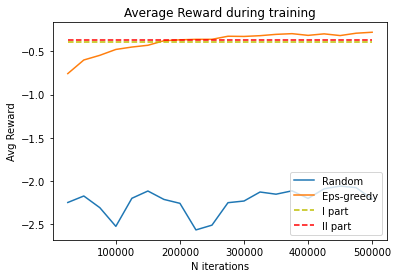

In [25]:
plt.plot(np.arange(25_000, 500_000 + 1, 25_000), eval_count_rand, label="Random")
plt.plot(np.arange(25_000, 500_000 + 1, 25_000), eval_count_eps, label="Eps-greedy")
plt.hlines(mean_reward_default, 25_000, 500_000, label="I part", color="y", linestyles="--")
plt.hlines(mean_reward_double, 25_000, 500_000, label="II part", color="r", linestyles="--")
plt.title("Average Reward during training")
plt.xlabel("N iterations")
plt.ylabel("Avg Reward")
plt.legend(loc="lower right");

В новой постановке количество состояний выростает в 21 раз, а средняя длина эпизода то же значительно вырастает. Поэтому подход с рандомной стратегией начинает сильно проигрывать эпсилон-жадной -- от каждой траектории эпизода рандомная стратегия обновляет слишком мало значений Q - т.к. довольно быстро действие рандомной расходится с реальной и проход останавливается. А вот эпсилон-жадная стратегия сильно чаще выбирает те же действия что и текущая оптимальная, что позволяет вытаскивать из каждого эпизода больше информации.

В результате эпсилон-жадная позволяет улучшить результаты относительно стратегий, не учитывающие подсчет карт.